In [1]:
import sys

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

sys.path.append('../../..')
from batchflow.opensets import PascalSegmentation, COCOSegmentation
from batchflow import Pipeline, B, V, C, W, R
from batchflow.models.torch import UNet, ResUNet, DenseUNet
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.metrics import SegmentationMetricsByPixels

from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
dataset = COCOSegmentation()          # dataset to train models on

In [4]:
# Global constants
NUM_ITERS = 90000                               # number of iterations to train each model for
N_REPS = 3                                      # number of times to repeat each model train
RESEARCH_NAME = 'research_coco'                      # name of Research object
DEVICES = [0, 1, 2, 3, 4, 5, 6, 7]                     # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 300
BATCH_SIZE = 22

In [5]:
domain = (Option('model_class', [UNet, ResUNet]))                         

In [6]:
model_config = {
                'inputs/labels/classes': 183,                
                'auto_build': True,
                'auto_build/filters' : 16,
                'optimizer': ('Adam', {'lr': 0.001}),
                "decay": dict(name='exp', gamma=0.1),
                "n_iters": 50000,
                'device': C('device'),
                'loss': 'ce'
            }

In [7]:
def process_mask(x):
    x = np.squeeze(x)
    np.place(x, x==255, 182)
    return x

In [8]:
size = (256, 256)
train_root = (dataset.train.p 
                 .load(fmt='image', src='images', dst='images')
                 .load(fmt='mask', src='masks', dst='labels')
                 .resize(size=size, src='images', dst='images')              
                 .resize(size=size, src='labels', dst='labels')                                              
                 .to_array(channels='first')                                
                 .to_array(channels='first', src='labels', dst='labels')    
                 .apply_transform_all(src='labels', dst='labels', func=process_mask)  
                 .multiply(multiplier=1/255)
                 .run_later(BATCH_SIZE, n_epochs=None, drop_last=True,
                             shuffle=True, prefetch=5)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_model('dynamic', C('model_class'), 'my_model', config=model_config)
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches='loss', save_to=V('loss'))
                 )

In [9]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('metrics')
                 .load(fmt='image', src='images', dst='images')
                 .load(fmt='mask', src='masks', dst='labels')
                 .resize(size=size, src='images', dst='images')              
                 .resize(size=size, src='labels', dst='labels')                                              
                 .to_array(channels='first')                                
                 .to_array(channels='first', src='labels', dst='labels')    
                 .apply_transform_all(src='labels', dst='labels', func=process_mask)  
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=B('predictions'))
                 .gather_metrics('class', B.labels, B.predictions, fmt='logits', 
                                 num_classes=183, axis=1, save_to=V('metrics', mode='a'))
                 )
    
    pipeline.run(30, n_iters=10, drop_last=False, shuffle=True)
    
    metrics = pipeline.v('metrics')
    eval_classes = np.arange(0, 182)
    accuracy = np.mean(np.sum([metrics.true_positive(l) for l in eval_classes], axis=0) / metrics.total_population())
    return accuracy

In [10]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables='loss',
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

In [ ]:
!rm -rf $RESEARCH_NAME

research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research_coco is starting...


Domain updated: 0:   2%|▏         | 8312/540000.0 [10:46<11:29:15, 12.86it/s]

In [18]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)
# results = research.load_results(concat_config=True)

CPU times: user 15min 37s, sys: 0 ns, total: 15min 37s
Wall time: 15min 37s


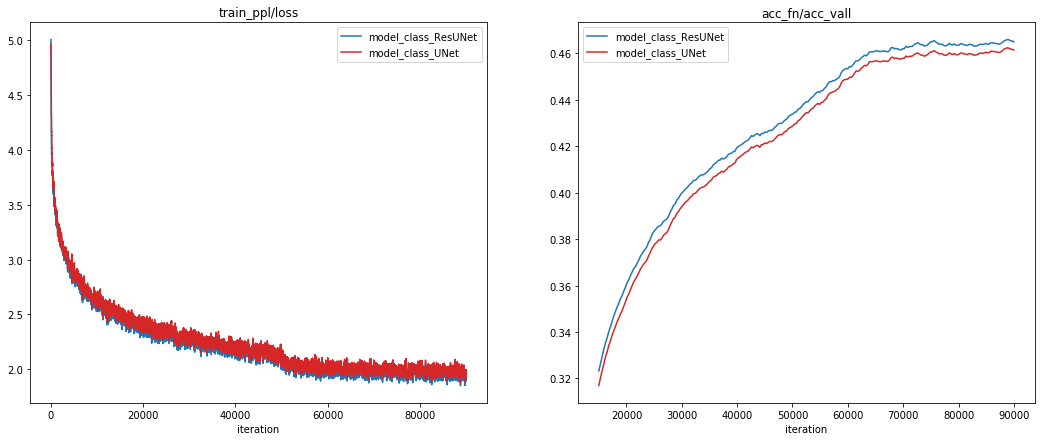

In [21]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=50)

In [23]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=20)

,acc_fn_1,acc_fn_2,acc_fn_0,acc_fn_mean,acc_fn_std
model_class_ResUNet,0.467231,0.462162,0.460900,0.463431,0.002736
model_class_UNet,0.459971,0.457076,0.460226,0.459091,0.001429
